In [1]:
import numpy as np 
import pandas as pd 
import math 
import os

import torch 
from torch import nn 
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import torch.optim as optim
#from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import classification_report
from sklearn.utils import shuffle

from torch.utils.data import Dataset, DataLoader
from PIL import Image

import pickle 
from torch.utils.data import Subset
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
#import seaborn as sns

import argparse
import logging

import math
import torch.nn.functional as F

import torch.utils.model_zoo as model_zoo
from torch.nn import init

import abc 
from typing import Union

from sklearn.metrics import roc_auc_score

import timm 

/home/askhat.sametov/.conda/envs/flow-tts-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Store all model initializations

### Xception and Core 

In [4]:
'''
# author: Zhiyuan Yan
# email: zhiyuanyan@link.cuhk.edu.cn
# date: 2023-0706

The code is mainly modified from GitHub link below:
https://github.com/ondyari/FaceForensics/blob/master/classification/network/xception.py
'''

#from metrics.registry import BACKBONE

# XCEPTION

logger = logging.getLogger(__name__)



class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super(SeparableConv2d, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size,
                               stride, padding, dilation, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(
            in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self, in_filters, out_filters, reps, strides=1, start_with_relu=True, grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides != 1:
            self.skip = nn.Conv2d(in_filters, out_filters,
                                  1, stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip = None

        self.relu = nn.ReLU(inplace=True)
        rep = []

        filters = in_filters
        if grow_first:   # whether the number of filters grows first
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters, out_filters,
                                       3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters, filters,
                                       3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters, out_filters,
                                       3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3, strides, 1))
        self.rep = nn.Sequential(*rep)

    def forward(self, inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x += skip
        return x

def add_gaussian_noise(ins, mean=0, stddev=0.2):
    noise = ins.data.new(ins.size()).normal_(mean, stddev)
    return ins + noise


#@BACKBONE.register_module(module_name="xception")
class Xception(nn.Module):
    """
    Xception optimized for the ImageNet dataset, as specified in
    https://arxiv.org/pdf/1610.02357.pdf
    """

    def __init__(self, xception_config):
        """ Constructor
        Args:
            xception_config: configuration file with the dict format
        """
        super(Xception, self).__init__()
        self.num_classes = xception_config["num_classes"]
        self.mode = xception_config["mode"]
        inc = xception_config["inc"]
        dropout = xception_config["dropout"]

        # Entry flow
        self.conv1 = nn.Conv2d(inc, 32, 3, 2, 0, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32, 64, 3, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        # do relu here

        self.block1 = Block(
            64, 128, 2, 2, start_with_relu=False, grow_first=True)
        self.block2 = Block(
            128, 256, 2, 2, start_with_relu=True, grow_first=True)
        self.block3 = Block(
            256, 728, 2, 2, start_with_relu=True, grow_first=True)

        # middle flow
        self.block4 = Block(
            728, 728, 3, 1, start_with_relu=True, grow_first=True)
        self.block5 = Block(
            728, 728, 3, 1, start_with_relu=True, grow_first=True)
        self.block6 = Block(
            728, 728, 3, 1, start_with_relu=True, grow_first=True)
        self.block7 = Block(
            728, 728, 3, 1, start_with_relu=True, grow_first=True)

        self.block8 = Block(
            728, 728, 3, 1, start_with_relu=True, grow_first=True)
        self.block9 = Block(
            728, 728, 3, 1, start_with_relu=True, grow_first=True)
        self.block10 = Block(
            728, 728, 3, 1, start_with_relu=True, grow_first=True)
        self.block11 = Block(
            728, 728, 3, 1, start_with_relu=True, grow_first=True)

        # Exit flow
        self.block12 = Block(
            728, 1024, 2, 2, start_with_relu=True, grow_first=False)

        self.conv3 = SeparableConv2d(1024, 1536, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(1536)

        # do relu here
        self.conv4 = SeparableConv2d(1536, 2048, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(2048)
        # used for iid
        final_channel = 2048
        if self.mode == 'adjust_channel_iid':
            final_channel = 512
            self.mode = 'adjust_channel'
        self.last_linear = nn.Linear(final_channel, self.num_classes)
        if dropout:
            self.last_linear = nn.Sequential(
                nn.Dropout(p=dropout),
                nn.Linear(final_channel, self.num_classes)
            )

        self.adjust_channel = nn.Sequential(
            nn.Conv2d(2048, 512, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=False),
        )
           
    def fea_part1_0(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)  

        return x

    def fea_part1_1(self, x):  
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x) 

        return x
    
    def fea_part1(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)     
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x) 

        return x
    
    def fea_part2(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        return x

    def fea_part3(self, x):
        if self.mode == "shallow_xception":
            return x
        else:
            x = self.block4(x)
            x = self.block5(x)
            x = self.block6(x)
            x = self.block7(x)
        return x

    def fea_part4(self, x):
        if self.mode == "shallow_xception":
            x = self.block12(x)
        else:
            x = self.block8(x)
            x = self.block9(x)
            x = self.block10(x)
            x = self.block11(x)
            x = self.block12(x)
        return x

    def fea_part5(self, x):
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.bn4(x)

        return x
     
    def features(self, input):
        x = self.fea_part1(input)    

        x = self.fea_part2(x)
        x = self.fea_part3(x)
        x = self.fea_part4(x)

        x = self.fea_part5(x)

        if self.mode == 'adjust_channel':
            x = self.adjust_channel(x)
        
        return x

    def classifier(self, features,id_feat=None):
        # for iid
        if self.mode == 'adjust_channel':
            x = features
        else:
            x = self.relu(features)

        if len(x.shape) == 4:
            x = F.adaptive_avg_pool2d(x, (1, 1))
            x = x.view(x.size(0), -1)
        self.last_emb = x
        # for iid
        if id_feat!=None:
            out = self.last_linear(x-id_feat)
        else:
            out = self.last_linear(x)
        return out

    def forward(self, input):
        x = self.features(input)
        out = self.classifier(x)
        return out
    



### Effnet 

In [4]:
from efficientnet_pytorch import EfficientNet

class EfficientNetB4(nn.Module):
    def __init__(self, efficientnetb4_config):
        super(EfficientNetB4, self).__init__()
        """ Constructor
        Args:
            efficientnetb4_config: configuration file with the dict format
        """
        self.num_classes = efficientnetb4_config["num_classes"]
        inc = efficientnetb4_config["inc"]
        self.dropout = efficientnetb4_config["dropout"]
        self.mode = efficientnetb4_config["mode"]

        # Load the EfficientNet-B4 model without pre-trained weights
        if efficientnetb4_config['pretrained']:
            self.efficientnet = EfficientNet.from_pretrained('efficientnet-b4',weights_path=efficientnetb4_config['pretrained'])  # FIXME: load the pretrained weights from online
        # self.efficientnet = EfficientNet.from_name('efficientnet-b4')
        else:
            self.efficientnet = EfficientNet.from_name('efficientnet-b4')
        # Modify the first convolutional layer to accept input tensors with 'inc' channels
        self.efficientnet._conv_stem = nn.Conv2d(inc, 48, kernel_size=3, stride=2, bias=False)

        # Remove the last layer (the classifier) from the EfficientNet-B4 model
        self.efficientnet._fc = nn.Identity()

        if self.dropout:
            # Add dropout layer if specified
            self.dropout_layer = nn.Dropout(p=self.dropout)

        # Initialize the last_layer layer
        self.last_layer = nn.Linear(1792, self.num_classes)

        if self.mode == 'adjust_channel':
            self.adjust_channel = nn.Sequential(
                nn.Conv2d(1792, 512, 1, 1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
            )

    def block_part1(self,x):
        x = self.efficientnet._swish(self.efficientnet._bn0(self.efficientnet._conv_stem(x)))
        # x = self.efficientnet._blocks[0:10](x)
        for idx, block in enumerate(self.efficientnet._blocks[:10]):
            drop_connect_rate = self.efficientnet._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx+0) / len(self.efficientnet._blocks)  # scale drop connect_rate
            x = block(x, drop_connect_rate=drop_connect_rate)
        return x

    def block_part2(self,x):
        for idx, block in enumerate(self.efficientnet._blocks[10:22]):
            drop_connect_rate = self.efficientnet._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx+10)  / len(self.efficientnet._blocks)  # scale drop connect_rate
            x = block(x, drop_connect_rate=drop_connect_rate)
        return x

    def block_part3(self,x):
        for idx, block in enumerate(self.efficientnet._blocks[22:]):
            drop_connect_rate = self.efficientnet._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx+22)  / len(self.efficientnet._blocks)  # scale drop connect_rate
            x = block(x, drop_connect_rate=drop_connect_rate)
        x = self.efficientnet._swish(self.efficientnet._bn1(self.efficientnet._conv_head(x)))
        return x


    def features(self, x):
        # Extract features from the EfficientNet-B4 model
        x = self.efficientnet.extract_features(x)
        if self.mode == 'adjust_channel':
            x = self.adjust_channel(x)
        return x
    def end_points(self,x):
        return self.efficientnet.extract_endpoints(x)
    def classifier(self, x):
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        
        # Apply dropout if specified
        if self.dropout:
            x = self.dropout_layer(x)

        # Apply last_layer layer
        self.last_emb = x
        y = self.last_layer(x)
        return y

    def forward(self, x):
        # Extract features and apply classifier layer
        x = self.features(x)
        # if False:
        #     x = F.adaptive_avg_pool2d(x, (1, 1))
        #     x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

### FFD 

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import sys

class SeparableConv2d(nn.Module):
  def __init__(self, c_in, c_out, ks, stride=1, padding=0, dilation=1, bias=False):
    super(SeparableConv2d, self).__init__()
    self.c = nn.Conv2d(c_in, c_in, ks, stride, padding, dilation, groups=c_in, bias=bias)
    self.pointwise = nn.Conv2d(c_in, c_out, 1, 1, 0, 1, 1, bias=bias)

  def forward(self, x):
    x = self.c(x)
    x = self.pointwise(x)
    return x

class Block(nn.Module):
  def __init__(self, c_in, c_out, reps, stride=1, start_with_relu=True, grow_first=True):
    super(Block, self).__init__()
    
    self.skip = None
    self.skip_bn = None
    if c_out != c_in or stride!= 1:
      self.skip = nn.Conv2d(c_in, c_out, 1, stride=stride, bias=False)
      self.skip_bn = nn.BatchNorm2d(c_out)

    self.relu = nn.ReLU(inplace=True)
    
    rep = []
    c = c_in
    if grow_first:
      rep.append(self.relu)
      rep.append(SeparableConv2d(c_in, c_out, 3, stride=1, padding=1, bias=False))
      rep.append(nn.BatchNorm2d(c_out))
      c = c_out
    
    for i in range(reps - 1):
      rep.append(self.relu)
      rep.append(SeparableConv2d(c, c, 3, stride=1, padding=1, bias=False))
      rep.append(nn.BatchNorm2d(c))

    if not grow_first:
      rep.append(self.relu)
      rep.append(SeparableConv2d(c_in, c_out, 3, stride=1, padding=1, bias=False))
      rep.append(nn.BatchNorm2d(c_out))
    
    if not start_with_relu:
      rep = rep[1:]
    else:
      rep[0] = nn.ReLU(inplace=False)

    if stride != 1:
      rep.append(nn.MaxPool2d(3, stride, 1))
    self.rep = nn.Sequential(*rep)

  def forward(self, inp):
    x = self.rep(inp)
    
    if self.skip is not None:
      y = self.skip(inp)
      y = self.skip_bn(y)
    else:
      y = inp
    
    x += y
    return x

class RegressionMap(nn.Module):
  def __init__(self, c_in):
    super(RegressionMap, self).__init__()
    self.c = SeparableConv2d(c_in, 1, 3, stride=1, padding=1, bias=False)
    self.s = nn.Sigmoid()

  def forward(self, x):
    mask = self.c(x)
    mask = self.s(mask)
    return mask, None

class TemplateMap(nn.Module):
  def __init__(self, c_in, templates):
    super(TemplateMap, self).__init__()
    self.c = Block(c_in, 364, 2, 2, start_with_relu=True, grow_first=False)
    self.l = nn.Linear(364, 10)
    self.relu = nn.ReLU(inplace=True)
    
    self.templates = templates

  def forward(self, x):
    v = self.c(x)
    v = self.relu(v)
    v = F.adaptive_avg_pool2d(v, (1,1))
    v = v.view(v.size(0), -1)
    v = self.l(v)
    mask = torch.mm(v, self.templates.reshape(10,361))
    mask = mask.reshape(x.shape[0], 1, 19, 19)

    return mask, v

class PCATemplateMap(nn.Module):
  def __init__(self, templates):
    super(PCATemplateMap, self).__init__()
    self.templates = templates

  def forward(self, x):
    fe = x.view(x.shape[0], x.shape[1], x.shape[2]*x.shape[3])
    fe = torch.transpose(fe, 1, 2)
    mu = torch.mean(fe, 2, keepdim=True)
    fea_diff = fe - mu
    
    cov_fea = torch.bmm(fea_diff, torch.transpose(fea_diff, 1, 2))
    B = self.templates.reshape(1, 10, 361).repeat(x.shape[0], 1, 1)
    D = torch.bmm(torch.bmm(B, cov_fea), torch.transpose(B, 1, 2))
    eigen_value, eigen_vector = D.symeig(eigenvectors=True)
    index = torch.tensor([9]).cuda()
    eigen = torch.index_select(eigen_vector, 2, index)

    v = eigen.squeeze(-1)
    mask = torch.mm(v, self.templates.reshape(10, 361))
    mask = mask.reshape(x.shape[0], 1, 19, 19)
    return mask, v

class Xception(nn.Module):
  """
  Xception optimized for the ImageNet dataset, as specified in
  https://arxiv.org/pdf/1610.02357.pdf
  """
  def __init__(self, maptype, templates, num_classes=1000):
    super(Xception, self).__init__()
    self.num_classes = num_classes

    self.conv1 = nn.Conv2d(3, 32, 3,2, 0, bias=False)
    self.bn1 = nn.BatchNorm2d(32)
    self.relu = nn.ReLU(inplace=True)

    self.conv2 = nn.Conv2d(32,64,3,bias=False)
    self.bn2 = nn.BatchNorm2d(64)

    self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
    self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
    self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)
    self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
    self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
    self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
    self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)
    self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
    self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
    self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
    self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)
    self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

    self.conv3 = SeparableConv2d(1024,1536,3,1,1)
    self.bn3 = nn.BatchNorm2d(1536)

    self.conv4 = SeparableConv2d(1536,2048,3,1,1)
    self.bn4 = nn.BatchNorm2d(2048)
    
    self.last_linear = nn.Linear(2048, num_classes)
    
    if maptype == 'none':
      self.map = [1, None]
    elif maptype == 'reg':
      self.map = RegressionMap(728)
    elif maptype == 'tmp':
      self.map = TemplateMap(728, templates)
    elif maptype == 'pca_tmp':
      self.map = PCATemplateMap(728)
    else:
      print('Unknown map type: `{0}`'.format(maptype))
      sys.exit()

  def features(self, input):
    x = self.conv1(input)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)

    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.block6(x)
    x = self.block7(x)
    mask, vec = self.map(x)
    x = x * mask
    x = self.block8(x)
    x = self.block9(x)
    x = self.block10(x)
    x = self.block11(x)
    x = self.block12(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)

    x = self.conv4(x)
    x = self.bn4(x)
    return x, mask, vec

  def logits(self, features):
    x = self.relu(features)
    x = F.adaptive_avg_pool2d(x, (1, 1))
    x = x.view(x.size(0), -1)
    x = self.last_linear(x)
    return x

  def forward(self, input):
    x, mask, vec = self.features(input)
    x = self.logits(x)
    return x

def init_weights(m):
  classname = m.__class__.__name__
  if classname.find('SeparableConv2d') != -1:
    m.c.weight.data.normal_(0.0, 0.01)
    if m.c.bias is not None:
      m.c.bias.data.fill_(0)
    m.pointwise.weight.data.normal_(0.0, 0.01)
    if m.pointwise.bias is not None:
      m.pointwise.bias.data.fill_(0)
  elif classname.find('Conv') != -1 or classname.find('Linear') != -1:
    m.weight.data.normal_(0.0, 0.01)
    if m.bias is not None:
      m.bias.data.fill_(0)
  elif classname.find('BatchNorm') != -1:
    m.weight.data.normal_(1.0, 0.01)
    m.bias.data.fill_(0)
  elif classname.find('LSTM') != -1:
    for i in m._parameters:
      if i.__class__.__name__.find('weight') != -1:
        i.data.normal_(0.0, 0.01)
      elif i.__class__.__name__.find('bias') != -1:
        i.bias.data.fill_(0)

class Model:
  def __init__(self, maptype='None', templates=None, num_classes=2, load_pretrain=True, model_path='./DeepfakeBench/training/weights/ffd_best.pth'):
    model = Xception(maptype, templates, num_classes=num_classes)
    if load_pretrain:
      state_dict = torch.load(model_path)
      
      new_state_dict = {}
      
      for k, v in state_dict.items():
        if k.startswith('backbone.'):
          new_key = k[len('backbone.'):]
        else:
          new_key = k 
        new_state_dict[new_key] = v

      
      for name, weights in new_state_dict.items():
        if 'pointwise' in name:
          new_state_dict[name] = weights.unsqueeze(-1).unsqueeze(-1)
      #del new_state_dict['fc.weight']
      #del new_state_dict['fc.bias']
      model.load_state_dict(new_state_dict, False)
    else:
      model.apply(init_weights)
    self.model = model

# new_state_dict = {}

# for k, v in ckpt.items():
#     if k.startswith('backbone.'):
#         new_key = k[len('backbone.'):]
#     else: 
#         new_key = k 
#     new_state_dict[new_key] = v

# model.load_state_dict(new_state_dict, strict=True)
# model

  def save(self, epoch, optim, model_dir):
    state = {'net': self.model.state_dict(), 'optim': optim.state_dict()}
    torch.save(state, '{0}/{1:06d}.tar'.format(model_dir, epoch))
    print('Saved model `{0}`'.format(epoch))

  def load(self, epoch, model_dir):
    filename = '{0}{1:06d}.tar'.format(model_dir, epoch)
    print('Loading model from {0}'.format(filename))
    if os.path.exists(filename):
      state = torch.load(filename)
      self.model.load_state_dict(state['net'])
    else:
      print('Failed to load model from {0}'.format(filename))

### Resnet

In [3]:
'''
# author: Zhiyuan Yan
# email: zhiyuanyan@link.cuhk.edu.cn
# date: 2023-0706

The code is for ResNet34 backbone.
'''

import os
import logging
from typing import Union
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

logger = logging.getLogger(__name__)

class ResNet34(nn.Module):
    def __init__(self, resnet_config):
        super(ResNet34, self).__init__()
        """ Constructor
        Args:
            resnet_config: configuration file with the dict format
        """
        self.num_classes = resnet_config["num_classes"]
        inc = resnet_config["inc"]
        self.mode = resnet_config["mode"]

        # Define layers of the backbone
        resnet = torchvision.models.resnet34(pretrained=True)  # FIXME: download the pretrained weights from online
        # resnet.conv1 = nn.Conv2d(inc, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet = torch.nn.Sequential(*list(resnet.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, self.num_classes)

        # if self.mode == 'adjust_channel':
        #     self.adjust_channel = nn.Sequential(
        #         nn.Conv2d(512, 512, 1, 1),
        #         nn.BatchNorm2d(512),
        #         nn.ReLU(inplace=True),
        #     )


    def features(self, inp):
        x = self.resnet(inp)
        return x

    def classifier(self, features):
        x = self.avgpool(features)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward(self, inp):
        x = self.features(inp)
        out = self.classifier(x)
        return out

## Load the models 

In [5]:
"""
config: dict 
possible backbones: Xception, Effnet, FFD, Resnet
"""
def load_model(ckpt_path, backbone = 'Xception'):
    ckpt = torch.load(ckpt_path)

    if backbone == 'Xception':
        config = {
            'num_classes': 2, 
            'mode': 'original',
            'inc': 3, 
            'dropout': False 
        }

        model = Xception(xception_config=config)
    elif backbone == 'Effnet':
        config = {
            'num_classes': 2, 
            'mode': 'original',
            'inc': 3, 
            'dropout': False,
            'pretrained': None 
        }

        model = EfficientNetB4(efficientnetb4_config=config)
    elif backbone == 'FFD':
        config = {
            'num_classes': 2, 
            'mode': 'original',
            'inc': 3, 
            'dropout': False,
            'maptype': 'reg' 
        }

        #model = Xception(xception_config=config) # different (second) Xception class 
        # will be initialized later 
    elif backbone == 'Resnet':
        config = {
            'num_classes': 2, 
            'mode': 'original',
            'inc': 3, 
            'dropout': False,
        }

        model = ResNet34(resnet_config=config)
    else: 
        print("There is no such backbone")
        return 

    if backbone != 'FFD':
        new_state_dict = {}

        for k, v in ckpt.items():
            if k.startswith('backbone.'):
                new_key = k[len('backbone.'):]
            else: 
                new_key = k 
            new_state_dict[new_key] = v

        model.load_state_dict(new_state_dict, strict=True)
        
    else: 
        new_state_dict = {}

        for k, v in ckpt.items():
            if k.startswith('backbone.'):
                new_key = k[len('backbone.'):]
            else: 
                new_key = k 
            
            if new_key.startswith('adjust_channel'):
                continue 

            new_key = new_key.replace('conv1', 'c').replace('skipbn', 'skip_bn') 
            if new_key == 'c.weight':
                new_key = 'conv1.weight'
            new_state_dict[new_key] = v 

        model = Xception(maptype='reg', templates=None, num_classes=2)
        model.load_state_dict(new_state_dict, strict=True)
    
    return model 

In [6]:
model = load_model(ckpt_path='./DeepfakeBench/training/weights/xception_best.pth', backbone='Xception')
model

/tmp/ipykernel_3676860/67314427.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path)


Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Co

In [7]:
model = model.to(device)

## Load dataset 

In [8]:
class RealFakeDataset(Dataset):
    def __init__(self, real_data_dir, fake_data_dir, transform=None):
        self.transform = transform
        self.data = []
        self.labels = []

        for dataset_dir in os.listdir(real_data_dir):
            dataset_path = os.path.join(real_data_dir, dataset_dir)
            if os.path.exists(dataset_path):
                for img_file in os.listdir(dataset_path):
                    img_path = os.path.join(dataset_path, img_file)
                    self.data.append(img_path)
                    self.labels.append(0)  # Label 0 for real images

        # Load fake images
        if fake_data_dir == None:
            return 
        
        for dataset_dir in os.listdir(fake_data_dir):
            dataset_path = os.path.join(fake_data_dir, dataset_dir)
            if os.path.exists(dataset_path):
                for img_file in os.listdir(dataset_path):
                    img_path = os.path.join(dataset_path, img_file)
                    self.data.append(img_path)
                    self.labels.append(1)  # Label 1 for fake images

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [9]:
# seed for reproducibility 
seed = 42
torch.manual_seed(seed)

def create_loader(batch_size=32):
    test_val_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

    real_data_dir = 'DeepfakeBench/datasets/rgb/UADFV/real/frames'
    fake_data_dir = 'DeepfakeBench/datasets/rgb/UADFV/fake/frames'

    # Full dataset for splitting
    full_dataset = RealFakeDataset(real_data_dir, fake_data_dir)

    train_size = 0
    val_size = 0
    test_size = len(full_dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    test_dataset.dataset.transform = test_val_transform

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return test_loader 

In [10]:
test_loader = create_loader(8)
print(f"Test set size: {len(test_loader.dataset)}")

Test set size: 3099


## Evaluate the model on test set 

In [11]:
criterion = nn.CrossEntropyLoss()

In [12]:
model.eval()
total_test_loss = 0.0
correct_test = 0
total_test = 0

y_true = []
y_pred_probs = []  # Store predicted probabilities for AUC calculation

with torch.no_grad():
    for inputs, labels in test_loader: 
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs) # outputs[0] of shape batch x 2 
        
        probabilities = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
        
        test_loss = criterion(outputs, labels)
        total_test_loss += test_loss.item() * inputs.size(0)
        
        predicted_labels = torch.argmax(outputs, dim=1)
        correct_test += (predicted_labels == labels).sum().item()
        total_test += labels.size(0)
        
        y_true.extend(labels.cpu().numpy())
        y_pred_probs.extend(probabilities[:, 1].cpu().numpy()) 


average_test_loss = total_test_loss / len(test_loader.dataset)
test_accuracy = correct_test / total_test 

# Calculate AUC score
auc_score = roc_auc_score(y_true, y_pred_probs)

print(f"Test Loss: {average_test_loss:.4f} - Test Accuracy: {test_accuracy:.4f} - AUC: {auc_score:.4f}")

Test Loss: 0.7224 - Test Accuracy: 0.6525 - AUC: 0.7747


## Prepare attacks 

In [12]:
def unnormalize(img):
    mean = torch.tensor([0.5, 0.5, 0.5], device=img.device).view(1, 3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5], device=img.device).view(1, 3, 1, 1)
    #mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    #std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img * std + mean

def normalize(img):
    mean = torch.tensor([0.5, 0.5, 0.5], device=img.device).view(1, 3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5], device=img.device).view(1, 3, 1, 1)
    return (img - mean) / std

In [13]:
from torchattacks import FGSM, MIFGSM, PGD

# Initialize attacks
fgsm_attack = FGSM(model, eps=0.03)
mifgsm_attack = MIFGSM(model, eps=0.03, steps=5)
pgd_attack = PGD(model, eps=0.03, alpha=0.01, steps=30)

## Evaluate on MIFGSM 

In [13]:
model.eval()
total_test_loss = 0.0
correct_test = 0
correct_adv = 0 
total_test = 0

criterion = nn.CrossEntropyLoss()

images_list, labels_list = [], []

y_true = []
y_pred = []
y_true_adv = []
y_pred_probs_adv = []
y_true_clean = []
y_pred_probs_clean = []

epsilon = 0.03 

for inputs, labels in test_loader: 
    inputs, labels = inputs.to(device), labels.to(device)
    inputs.requires_grad = True 

    perturbed_inputs = mifgsm_attack(unnormalize(inputs), labels)
    adv_outputs = model(normalize(perturbed_inputs))

    adv_probs = F.softmax(adv_outputs, dim=1)

    adv_predicted_labels = torch.argmax(adv_probs, dim=1)
    correct_adv += (adv_predicted_labels == labels).sum().item()

    y_true_adv.extend(labels.cpu().numpy())
    y_pred_probs_adv.extend(adv_probs[:, 1].detach().cpu().numpy())

    outputs = model(inputs)
    
    clean_probs = F.softmax(outputs, dim=1)
    predicted_labels = torch.argmax(clean_probs, dim=1)
    correct_test += (predicted_labels == labels).sum().item()
    
    total_test += labels.size(0)
    
    y_true_clean.extend(labels.cpu().numpy())
    y_pred_probs_clean.extend(clean_probs[:, 1].detach().cpu().numpy())  

    images_list.append(perturbed_inputs.detach().cpu())
    labels_list.append(labels.detach().cpu())

test_accuracy = correct_test / total_test 
adv_accuracy = correct_adv / total_test 

auc_score_clean = roc_auc_score(y_true_clean, y_pred_probs_clean)
auc_score_adv = roc_auc_score(y_true_adv, y_pred_probs_adv)

print(f"Adversarial attacks: Adversarial data accuracy: {adv_accuracy:.4f} - Test Accuracy on UADFV dataset: {test_accuracy:.4f}")
print(f"AUC Score on Clean Data: {auc_score_clean:.4f}")
print(f"AUC Score on Adversarial Data: {auc_score_adv:.4f}")

Adversarial attacks: Adversarial data accuracy: 0.0003 - Test Accuracy on UADFV dataset: 0.8451
AUC Score on Clean Data: 0.9609
AUC Score on Adversarial Data: 0.0000


In [14]:
model_name = 'core'

In [15]:
# save adversarial images
all_adv_images = torch.cat(images_list, dim=0)
all_labels = torch.cat(labels_list, dim=0)

# need to specify path according to model and attack 
save_path = f'./DeepfakeBench/training/adv_images/mifgsm_{model_name}_uadf.pt'

torch.save({'adversarial_images': all_adv_images, 'labels': all_labels}, save_path)
print('adversarial data saved') 

adversarial data saved


## Apply PGD attack 

In [23]:
model.eval()
total_test_loss = 0.0
correct_test = 0
correct_adv = 0 
total_test = 0

criterion = nn.CrossEntropyLoss()

images_list, labels_list = [], []

y_true = []
y_pred = []
y_true_adv = []
y_pred_probs_adv = []
y_true_clean = []
y_pred_probs_clean = []

epsilon = 0.03 

for inputs, labels in test_loader: 
    inputs, labels = inputs.to(device), labels.to(device)
    inputs.requires_grad = True 

    perturbed_inputs = pgd_attack(unnormalize(inputs), labels)
    adv_outputs = model(normalize(perturbed_inputs))

    adv_probs = F.softmax(adv_outputs, dim=1)

    adv_predicted_labels = torch.argmax(adv_probs, dim=1)
    
    correct_adv += (adv_predicted_labels == labels).sum().item()

    y_true_adv.extend(labels.cpu().numpy())
    y_pred_probs_adv.extend(adv_probs[:, 1].detach().cpu().numpy())

    outputs = model(inputs)
    
    clean_probs = F.softmax(outputs, dim=1)
    predicted_labels = torch.argmax(clean_probs, dim=1)
    correct_test += (predicted_labels == labels).sum().item()
    
    total_test += labels.size(0)
    
    y_true_clean.extend(labels.cpu().numpy())
    y_pred_probs_clean.extend(clean_probs[:, 1].detach().cpu().numpy())  

    images_list.append(perturbed_inputs.detach().cpu())
    labels_list.append(labels.detach().cpu())


test_accuracy = correct_test / total_test 
adv_accuracy = correct_adv / total_test 

auc_score_clean = roc_auc_score(y_true_clean, y_pred_probs_clean)
auc_score_adv = roc_auc_score(y_true_adv, y_pred_probs_adv)

print(f"Adversarial attacks: Adversarial data accuracy: {adv_accuracy:.4f} - Test Accuracy on UADFV dataset: {test_accuracy:.4f}")
print(f"AUC Score on Clean Data: {auc_score_clean:.4f}")
print(f"AUC Score on Adversarial Data: {auc_score_adv:.4f}")

Adversarial attacks: Adversarial data accuracy: 0.0000 - Test Accuracy on UADFV dataset: 0.6525
AUC Score on Clean Data: 0.7747
AUC Score on Adversarial Data: 0.0000


In [24]:
model_name = 'cnnaug'

In [25]:
# save adversarial images
all_adv_images = torch.cat(images_list, dim=0)
all_labels = torch.cat(labels_list, dim=0)

save_path = f'./DeepfakeBench/training/adv_images/pgd_{model_name}_uadf.pt'

torch.save({'adversarial_images': all_adv_images, 'labels': all_labels}, save_path)
print('adversarial data saved') 

adversarial data saved


## BlackBox Attacks 

In [9]:
class AdversarialDataset(Dataset):
    def __init__(self, file_path):
        data = torch.load(file_path)
        self.images = data['adversarial_images']
        self.labels = data['labels']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [45]:
adv_model_name = 'core'
#adv_dataset_path = f'./DeepfakeBench/training/adv_images/mifgsm_{adv_model_name}_uadf.pt'
adv_dataset_path = f'./DeepfakeBench/training/adv_images/pgd_{adv_model_name}_uadf.pt'

In [46]:
adversarial_dataset = AdversarialDataset(adv_dataset_path)
batch_size = 4 

test_loader = DataLoader(adversarial_dataset, batch_size=batch_size, shuffle=False)

/tmp/ipykernel_1604589/2554490810.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


### Evaluate 

In [47]:
model.eval()
total_test_loss = 0.0
correct_test = 0
correct_adv = 0 
total_test = 0

criterion = nn.CrossEntropyLoss()

images_list, labels_list = [], []

y_true= []
y_pred_probs = []


for inputs, labels in test_loader: 
    inputs, labels = inputs.to(device), labels.to(device)
    
    outputs = model(normalize(inputs)) # need to normalize adversarial images 
    
    probs = F.softmax(outputs, dim=1)
    predicted_labels = torch.argmax(probs, dim=1)
    correct_test += (predicted_labels == labels).sum().item()
    
    total_test += labels.size(0)
    
    y_true.extend(labels.cpu().numpy())
    y_pred_probs.extend(probs[:, 1].detach().cpu().numpy())  


test_accuracy = correct_test / total_test 

auc_score = roc_auc_score(y_true, y_pred_probs)

print(f"Test Accuracy on UADFV dataset: {test_accuracy:.4f}")
print(f"AUC Score on Adv Data: {auc_score:.4f}")

Test Accuracy on UADFV dataset: 0.3295
AUC Score on Adv Data: 0.2556


## Visualize attacks 

In [ ]:
# visualize adversarial images 

plt.figure(figsize=(12, 8))

images, labels = next(iter(test_loader))[0], next(iter(test_loader))[1]

for i, image in enumerate(images): 
    image = image.permute(1, 2, 0).numpy()
    plt.subplot(1, 4, i + 1)
    plt.imshow(image)
    plt.title(f'label {labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()     

In [14]:
# Visualize different attacks 

x_test_one, y_test_one = next(iter(test_loader))
x_test_one, y_test_one = x_test_one.to(device), y_test_one.to(device)
x_test_one.requires_grad = True

# Initialize attacks
mifgsm_attack = MIFGSM(model, eps=0.03, steps=5)
pgd_attack = PGD(model, eps=0.03, alpha=0.01, steps=30)

# Generate adversarial examples
x_test_one = unnormalize(x_test_one)

#x_test_adv_fgsm = fgsm_attack(x_test_one, y_test_one)
x_test_adv_mi = mifgsm_attack(x_test_one, y_test_one)
x_test_adv_pgd = pgd_attack(x_test_one, y_test_one)

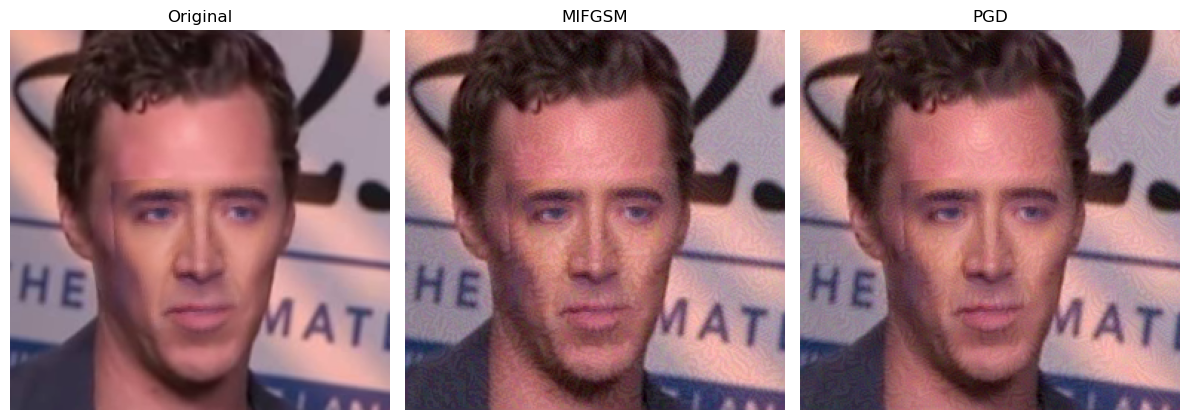

In [26]:
# Compare images: Original vs Adversarial
# fake image 
samples = [x_test_one[0], x_test_adv_mi[0], x_test_adv_pgd[0]]
titles = ["Original", "MIFGSM", "PGD"]

plt.figure(figsize=(12, 8))
for i, image in enumerate(samples):
    image = image.detach().cpu().permute(1, 2, 0).numpy()
    plt.subplot(1, 3, i + 1)
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

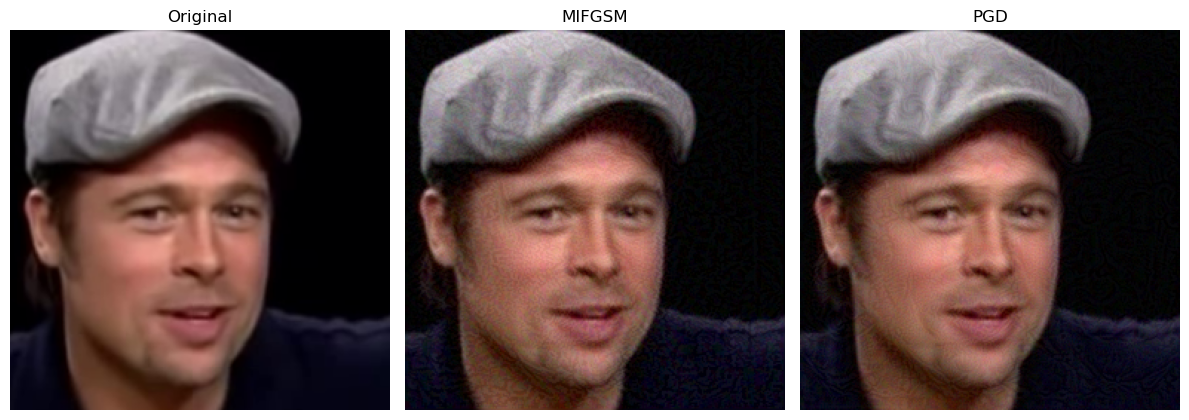

In [24]:
# Compare images: Original vs Adversarial
# real image 
samples = [x_test_one[4], x_test_adv_mi[4], x_test_adv_pgd[4]]
titles = ["Original", "MIFGSM", "PGD"]

plt.figure(figsize=(12, 8))
for i, image in enumerate(samples):
    image = image.detach().cpu().permute(1, 2, 0).numpy()
    plt.subplot(1, 3, i + 1)
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()